## 导入必要的库

In [16]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

from sklearn.inspection import PartialDependenceDisplay
# from alibi.explainers import ALE, plot_ale
import shap
import ipywidgets as widgets
from IPython.display import display


plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

In [17]:
data = pd.read_csv("E:\\竞赛\\服创赛-A08\\data\\特征集\\new_features.csv")
delete_feature = ['Unnamed: 0','个人编码']
data = data.drop(delete_feature,axis=1)
data.shape

(16000, 490)

In [18]:
data = data.fillna(0)

## 载入模型和特征

In [19]:
# 加载rf模型和特征列表
loaded_data_rf = joblib.load("E:\PyCharm\contest-A08\model_development\models\\rf_model\\RF_19_0.92255.pkl")
rf_model = loaded_data_rf['model']
rf_features = loaded_data_rf['features']

rf_selected_features = data[rf_features]
rf_selected_features.info()
rf_selected_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ALL_SUM                16000 non-null  float64
 1   治疗费用在总金额占比             16000 non-null  float64
 2   交易时间_NN                16000 non-null  int64  
 3   交易时间_NN_and_就诊的月数      16000 non-null  int64  
 4   药品费发生金额_SUM_波动         16000 non-null  float64
 5   中成药费发生金额_SUM_波动        16000 non-null  float64
 6   基本统筹基金支付金额_SUM_波动      16000 non-null  float64
 7   月就诊天数差                 16000 non-null  float64
 8   月统筹金额差                 16000 non-null  float64
 9   月药品金额差                 16000 non-null  float64
 10  医院_药品_AVG_调整           16000 non-null  float64
 11  个人账户金额_SUM_调整          16000 non-null  float64
 12  中草药费发生金额_SUM_病种费用标准差值  16000 non-null  float64
 13  月就诊次数_MAX_医院费用标准差值     16000 non-null  float64
 14  月统筹金额_MAX_医院费用标准差值     16000 non-null  float64
 15  月就

(16000, 19)

In [20]:
# 加载lgb模型和特征列表
loaded_data_lgb = joblib.load("E:\PyCharm\contest-A08\model_development\models\lgb_model\lgbm_12_0.92814.pkl")
lgb_model = loaded_data_lgb['model']
lgb_features = loaded_data_lgb['features']

lgb_selected_features = data[lgb_features]
lgb_selected_features.info()
lgb_selected_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   月药品金额_MAX              16000 non-null  float64
 1   顺序号_NN                 16000 non-null  int64  
 2   本次审批金额_SUM             16000 non-null  float64
 3   交易时间_NN                16000 non-null  int64  
 4   治疗费发生金额_SUM_波动         16000 non-null  float64
 5   非账户支付金额_SUM_波动         16000 non-null  float64
 6   月统筹金额差                 16000 non-null  float64
 7   医院_统筹金_MAX_病种费用标准差值    16000 non-null  float64
 8   医用材料发生金额_SUM_病种费用标准差值  16000 non-null  float64
 9   月就诊天数_AVG_病种平均费用差      16000 non-null  float64
 10  医院_就诊天数_AVG_病种平均费用差    16000 non-null  float64
 11  中成药费发生金额_SUM_病种平均费用差   16000 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 1.5 MB


(16000, 12)

In [21]:
X = data.drop('RES',axis=1)
y = data['RES']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.25)
X_test.shape

(4000, 489)

## LIME（局部可解释模型-不透明预测）

LIME（局部可解释模型-不透明预测）是一种用于增加复杂机器学习模型可解释性的技术。其核心思想是在模型的单个预测周围创建一个局部可解释的简单模型。

**注意：** LIME解释的质量高度依赖于局部邻域数据点的选择和生成方式

In [23]:
# 以rf为例
# 使用选定的特征
rf_selected_features = data[rf_features]
class_names = ['0','1']  

X_train, X_test, y_train, y_test = train_test_split(rf_selected_features, data['RES'],test_size=0.25, random_state=42)

# 选择一个实例进行解释
test_idx = 10
test_instance = rf_selected_features.iloc[test_idx]

# 初始化LIME解释器
explainer = lime_tabular.LimeTabularExplainer(
    training_data=rf_selected_features.values,
    feature_names=rf_features,
    class_names=class_names,
    mode='classification', 
    # 调整核宽度，较小的值意味着只有更接近原始实例的数据点才具有较高的权重
    # kernel_width=0.8
)

# 解释单个预测实例，传递 num_samples 参数
exp = explainer.explain_instance(
    data_row=test_instance.values, 
    predict_fn=rf_model.predict_proba,
    num_features=len(rf_features),
    # 增加生成的样本数量，增加局部解释的准确性
    num_samples=5000, 
)

D:\Anaconda3\envs\A08\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [24]:
exp.show_in_notebook(show_table=True)

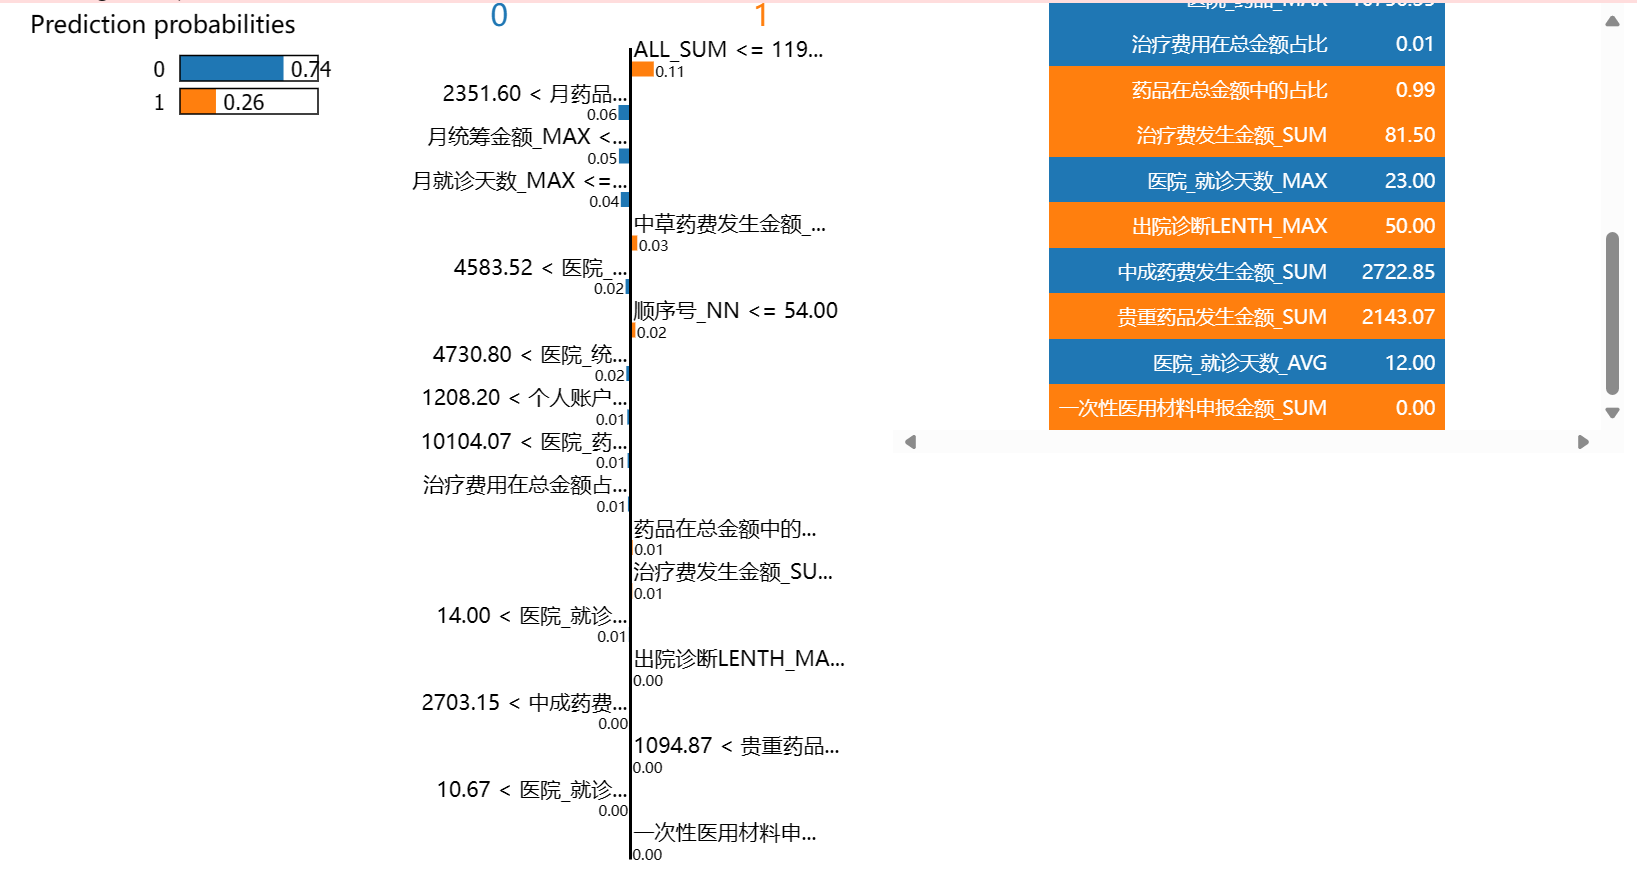

这张图片展示了使用LIME生成的模型预测解释的结果。从这张图片可以提取以下信息：

- **预测概率**：模型预测这个实例属于类别0的概率为0.74（74%），属于类别1的概率为0.26（26%）。这意味着模型相对更倾向于将该实例分类为类别0。

- **特征影响**：右侧是条形图，显示了影响模型预测的主要特征及中所见，特征的颜色代表它们的影响方向和强度：
  - **蓝色条形**：表示这些特征的当前值增加了实例被分类为类别0的概率。
  - **橙色条形**：表示这些特征的当前值增加了实例被分类为类别1的概率。

- **特征贡献解释**：例如，“ALL_SUM <= 119...”这个特征的值小于或等于119，对分类为类别0具有很强的正面影响（蓝色条形很长），而ALL“运行中基线点位_SUM”这个特征对分类为类别1具有很大的正面影响（橙色条形很长）。

- **特征实际值**：在条形图的右侧，你可以看到每征名称在训练和解释过程中是一致的。

## 部分依赖图（PDP）

PDP显示一个特征在不同取值下对模型预测结果的平均影响。它适用于捕捉特征的平均影响，但可能不会很好地处理特征之间的相互作用。

In [ ]:
# 创建下拉框
dropdown = widgets.Dropdown(
    options=rf_features,
    value=rf_features[0],
    description='选择特征:',
    disabled=False,
)

# 定义绘制PDP的函数
def plot_pdp(feature):
    PartialDependenceDisplay.from_estimator(rf_model, rf_selected_features, [feature])
    plt.show()

# 创建交互式控件
widgets.interactive(plot_pdp, feature=dropdown)  # 每次选择都会调用函数，反应较慢

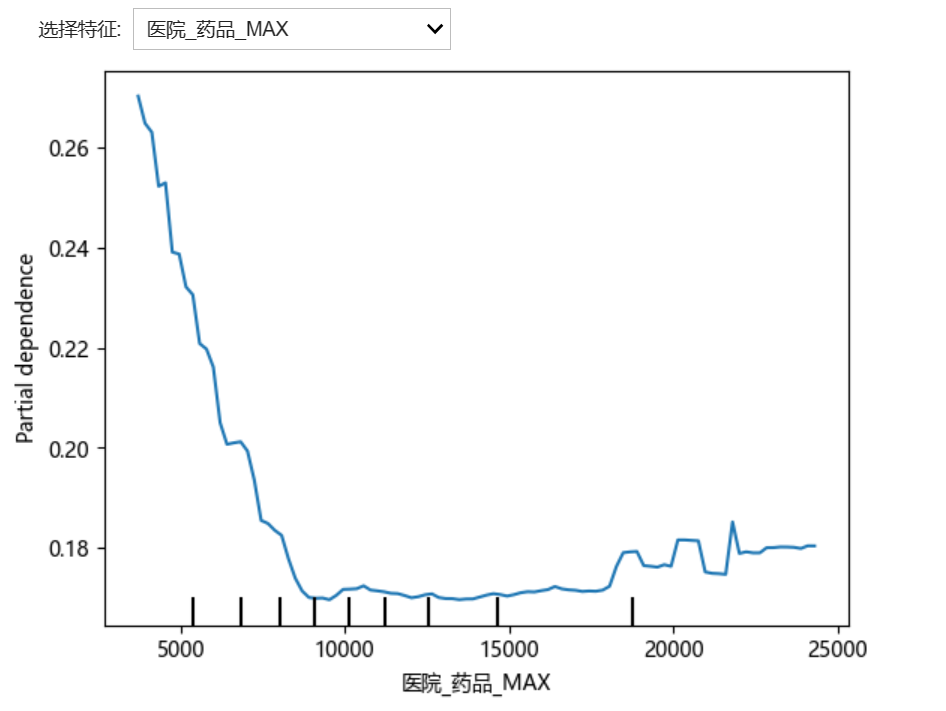

该局部依赖关系图显示了目标变量与标有 "医院_药品_MAX "的特征之间的关系。随着特征值的增加，目标变量的部分依赖性急剧下降，直到 x 轴上的 8500 左右才开始趋于平稳。这表明，"医院_药品_MAX "的较低值与目标变量具有较高的正相关性，而在某一点之后（约 8500），特征值的变化所产生的影响就不那么明显了。底部的黑色垂直线代表特征分布的十分位数（第 10 个百分位数）标记，有助于了解特征范围内数据点的密度。

## SHAP

`SHAP`（SHapley Additive exPlanations）是一个流行的Python库，用于解释机器学习模型的预测。它提供了一系列的方法和技术来增强模型的可解释性，以下是其中一些主要的方法：

1. **SHAP值（SHAP Values）**:
   - SHAP值是基于博弈论中的Shapley值，用于量化每个特征对单个预测的贡献。
   - 这些值可以解释为特征如何正面或负面地影响模型的预测。

2. **依赖图（Dependence Plots）**:
   - 依赖图显示了一个特征的值如何影响其对模型预测的SHAP值。
   - 这些图有助于理解特征间的关系以及特定特征如何影响模型的输出。

3. **总结图（Summary Plots）**:
   - 总结图提供了一个全面的视图，展示了所有特征对模型预测的整体影响。
   - 它可以帮助识别模型预测中最重要的特征。

4. **力量图（Force Plots）**:
   - 力量图提供了单个预测的详细解释。
   - 它显示了不同特征如何推动模型预测向一个特定的方向（更高或更低）。

5. **决策图（Decision Plots）**:
   - 决策图是一个新工具，用于理解单个预测的整个决策过程。
   - 它显示了从模型的基线输出开始，每个特征如何逐步改变预测值。

6. **交互影响图（Interaction Values）**:
   - SHAP还提供了用于检测特征间相互作用的方法。
   - 这些值有助于理解当两个特征同时改变时，它们是如何联合影响模型预测的。

7. **水平线图（Waterfall Plots）**:
   - 水平线图提供了单个预测的另一种可视化方式。
   - 它显示了每个说是有价值的，也可以帮助最终用户更好地理解和信任模型的预测。

### SHAP值

In [ ]:
# 创建一个SHAP解释器
explainer = shap.Explainer(lgb_model)

# 计算SHAP值
shap_values = explainer.shap_values(lgb_selected_features)

### 依赖图

In [ ]:
# 创建主特征选择下拉框，默认为'月药品金额_MAX'
primary_feature = '月药品金额_MAX'
primary_feature_selector = widgets.Dropdown(
    options=lgb_selected_features.columns.tolist(),
    value=primary_feature,
    description='主特征:',
    disabled=False,
)

# 创建第二特征选择下拉框
secondary_feature_selector = widgets.Dropdown(
    options=[feat for feat in lgb_selected_features.columns if feat != primary_feature],
    description='第二特征:',
    disabled=False,
)

# 绘制SHAP依赖图的函数
def plot_shap_dependence(primary_feature, secondary_feature):
    shap.dependence_plot(
        primary_feature,
        shap_values,  # 如果是回归模型，这里就是 shap_values
        lgb_selected_features,
        interaction_index=secondary_feature
    )
    plt.show()

# 当选择变化时更新图
def on_change(change):
    clear_output(wait=True)
    display(primary_feature_selector, secondary_feature_selector)
    plot_shap_dependence(primary_feature_selector.value, secondary_feature_selector.value)

# 观察下拉框的变化
primary_feature_selector.observe(on_change, names='value')
secondary_feature_selector.observe(on_change, names='value')

# 显示下拉框
display(primary_feature_selector, secondary_feature_selector)

# 初始绘图
plot_shap_dependence(primary_feature_selector.value, secondary_feature_selector.value)

**可视化结果显示在log中**

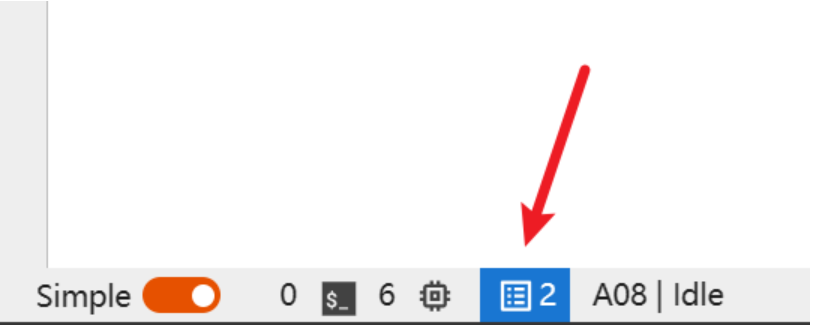

------------------

**图像说明**

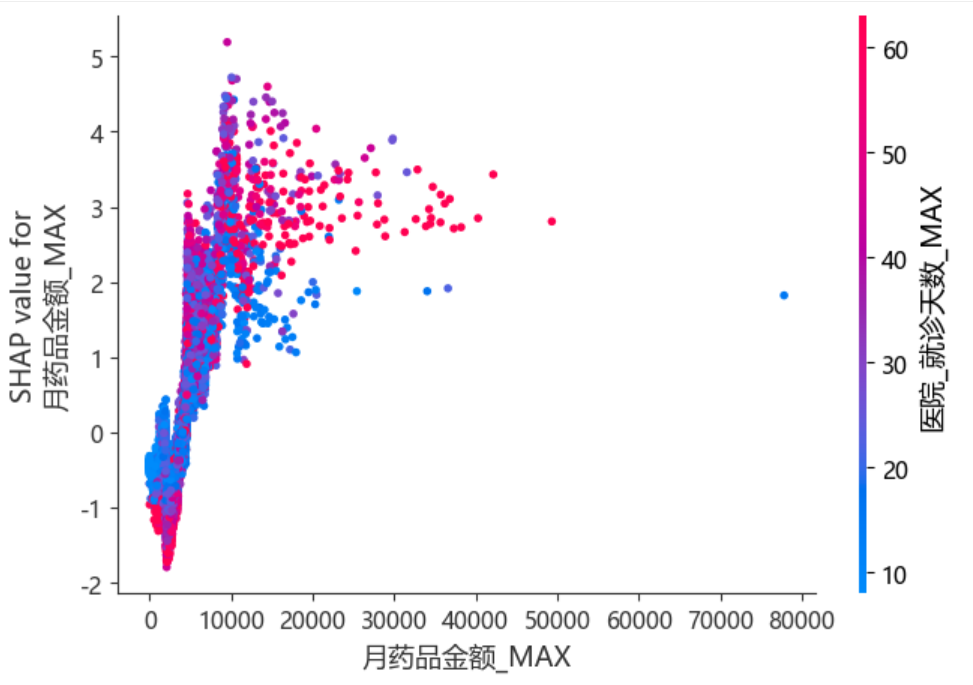

1. **X轴**：显示的是‘月药品金额_MAX’特征的值。特征的值范围从0到大约80000。

2. **Y轴**：表示SHAP值，即该特征值对模型输出预测的影响。SHAP值表示该特征如何影响每个样本的预测结果。

3. **颜色**：点的颜色代表了另一个特征的值，“医院_就诊天数_MAX”，表示与X轴上特征不同的另一个特征。

4. **数据点**：每个点代表数据集中的一个样本。点的颜色越接近红色，表明“医院_就诊天数_MAX”的值越高；颜色越接近蓝色，其值越低。

解释图表：

- 当“月药品金额_MAX”特征的值很小时（接近0），SHAP值主要分布在0附近，这表明该特征值对模型预测的影响较小。
- 当“月药品金额_MAX”增加时，SHAP值分布的范围也增大，显示出正值和负值，这可能表示该特征对于不同的样本有不同的影响，可能正面影响一些样本的预测结果，负面影响其他的。
- 在“月药品金额_MAX”较大的值域中，可以看到一些高的正SHAP值，这暗示在这个值域中该特征对模型预测的正影响更为显著。
- 点的颜色变化表示随着“医院_就诊天数_MAX”的增加，“月药品金额_MAX”的SHAP值也可能受到影响。例如，一些具有高“医院_就诊天数_MAX”值的样本（红色点）似乎具有更高的正SHAP值。

### 总结图

In [ ]:
shap.summary_plot(shap_values, lgb_selected_features)

这个图是一个SHAP总结图（Summary Plot），它展示了各个特征对模型预测贡献的概览。在这个图中，每一行代表一个特征，每个点代表一个数据点（即模型的一个预测）。SHAP值的大小和方向（正或负）表明了特征对模型预测的影响。下：

- **横轴（SHAP值）**：表示该特征对模型预测的影响大小。SHAP值越大，表示该特征对模型预测的正面影响越大；SHAP值越小（或越负），表示负面影响越大。

- **点的颜色**：从蓝色到红色代表特征值从低到高。例如，深蓝色的点表示较低的特征值，而深红色的点表示较高的特征值。

- **特征重要性**：图中的特征按其对模型影响的绝对大小排序，位于顶部的特征对模型的输出影响最大。

在提供的图中：

- **“月药品金额_MAX”** 出现在最顶部，这表示它对模型的输出有最大的整体影响。高值（红色点）似乎通常会导致更高的SHAP值，这可能意味着更高的“月药品金额_MAX”值会导致模型预测结果的增加。

- 下面的几行显示了其他特征及其对模型预测的影响，例如“中药药费总金额_SUM”特征的最大值、总和或平均值。

- 特征的贡献可以是正的（推动模型预测结果更高）或负的（降低预测结果）。例如，某些特征对于某些样本有正影响（点在0值右侧），而对于其他以理解不同特征值如何影响模型的输出。

### 力量图

In [ ]:
# 选择一个样本来绘制力量图。这里选择第一个样本作为示例
sample_index = 0
shap.initjs() # 初始化JavaScript可视化环境

# 绘制力量图
# 注意：不要对expected_value进行索引
force_plot = shap.force_plot(
    explainer.expected_value, # 使用这个标量值
    shap_values[sample_index], # 直接使用SHAP值
    lgb_selected_features.iloc[sample_index,:],
    # matplotlib=True # 设置matplotlib=True来生成非交互式的图表
)
force_plot

In [ ]:
expected_value = explainer.expected_value if isinstance(explainer.expected_value, float) else explainer.expected_value[1]

# 生成集合力度图
shap.force_plot(
    expected_value,
    shap_values[:500], # 取前500个样本的SHAP值
    lgb_selected_features.iloc[:500,:],
    # 如果需要非交互式图像
    # matplotlib=True
)

### 决策图

In [ ]:
# 初始化JavaScript环境
shap.initjs()

# 选择一个样本来生成决策图
sample_index = 0

# 对于二分类问题，我们通常关注正类的SHAP值
# 绘制决策图
decision_plot = shap.decision_plot(
    explainer.expected_value, # 使用期望值
    shap_values[sample_index], # 使用SHAP值
    lgb_selected_features.iloc[sample_index], # 该样本的特征值
    feature_names=lgb_selected_features.columns.tolist() # 特征名称
)

SHAP决策图展示了如何根据各个特征对单个样本的预测贡献来解释模型的预测结果。在这张图中，横轴显示了累积的SHAP值，纵轴显示了各个特征：

- 图的左端开始于基线值（通常是模型的平均输出），在此示例中大约7 0-6.5` 的SHAP值。
- 向右移动的线显示了每个特征对模型输出的贡献。线向上移动意味着该特征对模型预测结果有正贡献（即使预测更可能属于正类），而线向下移动表示该特征对预测有负贡献（即使预测更可能属于负类）。
- 每个特征右侧的数字表示该特征的实际数值。
- 每个特征的点在横轴上的位置表示其SHAP值，它是该特征对预测结果的贡献度量。例如，“月药品金额_MAX”特征的SHAP值是正的，并且相对较大，这意味着它对模型预测正类结果有很大的正影响。
- 图的末端显示了模型的最终预测（在本例中大约是 `-3.0` 其他特征则影响较小。

### 水平线图

In [ ]:
# 绘制 SHAP 值的水平条形图
shap.summary_plot(shap_values, lgb_selected_features, plot_type="bar")